In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

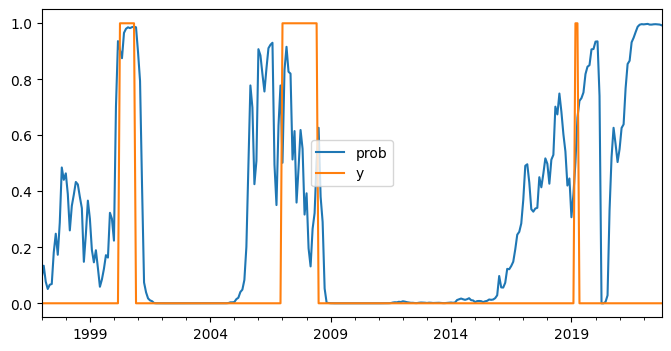

In [40]:
# CELL 1: OOS probability series
oos = pd.read_csv("../../../data/processed/recession_prob_12m_oos_multivar.csv",
                  index_col=0, parse_dates=True).rename(columns={"phat":"prob","y":"y"})
oos = oos.asfreq("ME")
oos.plot(figsize=(8,4))
plt.show()

In [41]:
start_date = oos.index[0]

In [42]:
# CELL 2: download prices and compute monthly returns
tickers = ["SPY", "VFITX"]
px = yf.download(tickers, start=start_date, auto_adjust=True, progress=False)["Close"]
px = px.resample("ME").last()

ret = px.pct_change().dropna()
ret.rename(columns={'SPY': 'EQ', 'VFITX': 'BD'}, inplace=True)
ret

Ticker,EQ,BD
Date,,
1997-02-28,0.009566,0.000983
1997-03-31,-0.044123,-0.013034
1997-04-30,0.062605,0.016123
1997-05-31,0.063207,0.008342
1997-06-30,0.041102,0.010031
...,...,...
2025-06-30,0.051386,0.012433
2025-07-31,0.023032,-0.004689
2025-08-31,0.020520,0.015434


In [43]:
df = oos.join(ret, how="inner").dropna()

In [44]:
# CELL 4: regime function
def apply_regime(prob: pd.Series, r_eq: pd.Series, r_bd: pd.Series,
                 threshold=0.60, lag_months=1, cost_bps=5):
    prob = prob.sort_index()
    r_eq = r_eq.reindex(prob.index).fillna(0.0)
    r_bd = r_bd.reindex(prob.index).fillna(0.0)

    # 1 = risk-off (bonds), 0 = risk-on (equities)
    signal = (prob >= threshold).astype(int).shift(lag_months).fillna(0).astype(int)

    # returns
    r_strat = (1 - signal) * r_eq + signal * r_bd

    # costs on switches
    switches = signal.diff().abs().fillna(0)
    cost = switches * (cost_bps / 10000.0)
    r_strat_net = r_strat - cost

    eq_curve = (1 + r_strat_net).cumprod()
    
    return r_strat_net, eq_curve, signal, switches

r_strat, curve, signal, switches = apply_regime(df["prob"], df["EQ"], df["BD"], threshold=0.60, lag_months=1, cost_bps=5)

In [45]:
# CELL 5: build benchmarks
bench = pd.DataFrame(index=df.index)
bench["EQ_only"]  = (1 + df["EQ"]).cumprod()
bench["BD_only"]  = (1 + df["BD"]).cumprod()
bench["60_40"]    = (1 + (0.6*df["EQ"] + 0.4*df["BD"])).cumprod()
bench["Strategy"] = curve
bench

,EQ_only,BD_only,60_40,Strategy
1997-02-28,1.009566,1.000983,1.006133,1.009566
1997-03-31,0.965020,0.987936,0.974251,0.965020
1997-04-30,1.025435,1.003865,1.017129,1.025435
1997-05-31,1.090250,1.012239,1.059097,1.090250
1997-06-30,1.135062,1.022393,1.089465,1.135062
...,...,...,...,...
2022-06-30,7.567621,3.007984,5.719816,8.297015
2022-07-31,8.264505,3.065785,6.079815,8.456450
2022-08-31,7.927297,2.976615,5.860240,8.210487
2022-09-30,7.194452,2.879713,5.458877,7.943201


In [46]:
# CELL 6: stats helper
def perform_stats(r: pd.Series, freq=12):
    ann_ret = (1 + r).prod()**(freq/len(r)) - 1
    ann_vol = r.std() * np.sqrt(freq)
    sharpe  = ann_ret / (ann_vol + 1e-12)
    dd = (1 + r).cumprod()
    peak = dd.cummax()
    mdd = ((dd/peak) - 1).min()
    # Sortino
    downside = r.where(r<0, 0)
    dvol = downside.std() * np.sqrt(freq)
    sortino = ann_ret / (dvol + 1e-12)
    return pd.Series({"AnnRet": ann_ret, "AnnVol": ann_vol, "Sharpe": sharpe, "MaxDD": mdd, "Sortino": sortino})

perf_tbl = pd.DataFrame({
    "Strategy": perform_stats(r_strat),
    "EQ_only":  perform_stats(df["EQ"]),
    "BD_only":  perform_stats(df["BD"]),
    "60_40":    perform_stats(0.6*df["EQ"] + 0.4*df["BD"])
}).T

perf_tbl

,AnnRet,AnnVol,Sharpe,MaxDD,Sortino
Strategy,0.083456,0.133703,0.624186,-0.491656,1.038498
EQ_only,0.082927,0.156038,0.531458,-0.507848,0.888466
BD_only,0.041594,0.046303,0.898318,-0.142237,1.766438
60_40,0.069979,0.092160,0.759318,-0.302479,1.310415


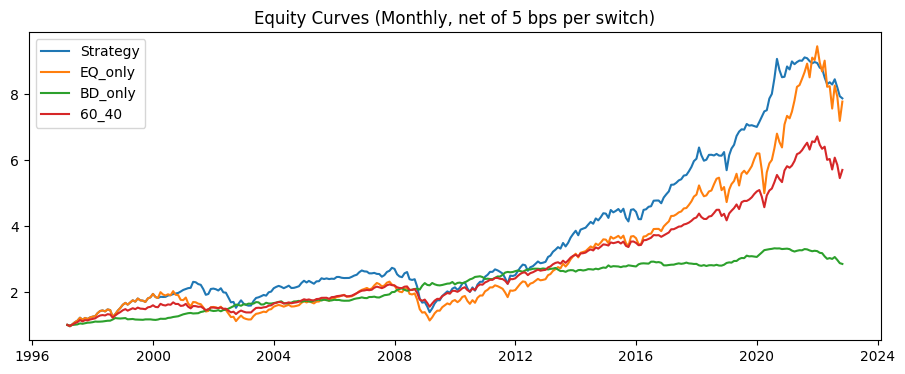

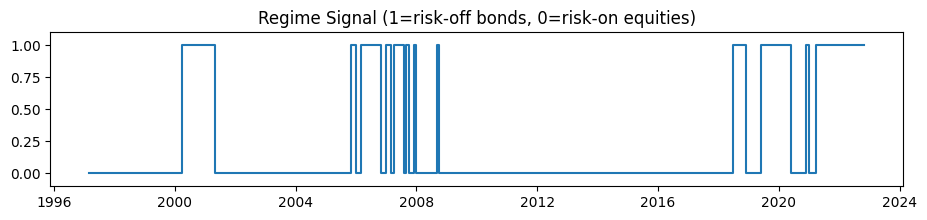

Switches per year: 0.8932038834951457


In [47]:
# CELL 7: curves
plt.figure(figsize=(11,4))
for c in ["Strategy", "EQ_only", "BD_only", "60_40"]:
    plt.plot(bench.index, bench[c], label=c)
    
plt.title("Equity Curves (Monthly, net of 5 bps per switch)")
plt.legend()
plt.show()

# Signal overlay
plt.figure(figsize=(11,2))
plt.plot(signal.index, signal, drawstyle="steps-post")
plt.title("Regime Signal (1=risk-off bonds, 0=risk-on equities)")
plt.ylim(-0.1, 1.1)
plt.show()

# Switching frequency
print("Switches per year:", switches.sum() / (len(switches)/12))

In [48]:
# CELL 8: grid over threshold and costs
th_grid = [0.50, 0.55, 0.60, 0.65, 0.70]
cost_grid = [0, 5, 10]  # bps per switch

rows = []
for th in th_grid:
    for cbps in cost_grid:
        r, _, sig, sw = apply_regime(df["prob"], df["EQ"], df["BD"],
                                     threshold=th, lag_months=1, cost_bps=cbps)
        s = perform_stats(r)
        rows.append({"threshold": th, "cost_bps": cbps, **s.to_dict(),
                     "switches_per_year": sw.sum() / (len(sw)/12)})
sens = pd.DataFrame(rows).sort_values(["cost_bps","threshold"])
sens


,threshold,cost_bps,AnnRet,AnnVol,Sharpe,MaxDD,Sortino,switches_per_year
0,0.50,0,0.079330,0.132578,0.598366,-0.476363,0.989157,0.737864
3,0.55,0,0.081344,0.133535,0.609158,-0.485067,1.012493,0.893204
6,0.60,0,0.083936,0.133704,0.627778,-0.490866,1.044782,0.893204
9,0.65,0,0.087142,0.136632,0.637791,-0.507848,1.071318,0.582524
12,0.70,0,0.087396,0.137589,0.635197,-0.507848,1.065612,0.660194
1,0.50,5,0.078930,0.132609,0.595210,-0.477190,0.983544,0.737864
4,0.55,5,0.080862,0.133548,0.605490,-0.485880,1.006043,0.893204
7,0.60,5,0.083456,0.133703,0.624186,-0.491656,1.038498,0.893204
10,0.65,5,0.086827,0.136637,0.635457,-0.507848,1.067244,0.582524
13,0.70,5,0.087042,0.137575,0.632686,-0.507848,1.061254,0.660194


In [49]:
# TODO: Bond portfolio tilt	Backtest long-short strategies along the yield curve
# TODO: Cross-market analysis	Compare U.S. vs Eurozone or China rates once your infra supports multiple regions
"""
.

🚀 What to Do Next (Structured Roadmap)
📘 Notebook 07 — Enhance the Regime Strategy

Goal: move from “binary recession switch” → “continuous, probability-weighted allocation”.

Replace binary signal with fractional weights:

Then allocate 𝑤 to bonds, 1 − 𝑤 to equities.
→ Reduces turnover, captures smoother regime transitions.

Add hysteresis (confirmation):
Require two consecutive months above 0.6 before switching risk-off; two below 0.5 to switch back.
→ Cuts noise, improves Sharpe.

Add “cash filter” or “bond momentum” layer:
When your model says “recession,” but bond momentum < 0, hold cash instead of bonds.

Re-run performance metrics and compare:
Plot Sharpe vs MaxDD vs turnover — find the efficient frontier of your signal design.

🧩 Notebook 08 — Model Refinement and ML

Goal: see if a better classifier gives you better signal stability.

Train Logistic Regression (baseline) vs Random Forest vs XGBoost using the same features.

Compare AUC, calibration, and probability smoothness.

Use model probabilities directly in the regime sizing (from Notebook 07).

📈 Notebook 09 — Backtest Expansion

Goal: test robustness & potential alpha.

Expand asset universe: include global equities (EFA), credit (LQD), gold (GLD).

Build a risk parity version using your model for cross-asset timing.

Test across decades (1970s–2020s) for regime consistency.

💡 Beyond the notebooks

Start integrating evaluation metrics like:

Information Coefficient between your signal and forward returns

Hit ratio during recessions

Skew/kurtosis of strategy returns

Later, we’ll move to cross-sectional prediction and factor timing (e.g., predicting relative performance between sectors).
"""